# Dropout regularization

In machine learning,
our goal is to discover general patterns.
For example, we might want to learn an association between genetic markers
and the development of dementia in adulthood. 
Our hope would be to uncover a pattern that could be applied successfully to assess risk for the entire population.

However, when we train models, we don't have access to the entire population (or current or potential humans).
Instead, we can access only a small, finite sample.
Even in a large hospital system, we might get hundreds of thousands of medical records. 
Given such a finite sample size, it's possible to uncover spurious associations 
that don't hold up for unseen data.

Let's consider an extreme pathological case. 
Imagine that you want to learn to predict
which people will repay their loans. 
A lender hires you as a data scientist 
to investigate the case and gives you complete files on 100 applicants,
of which 5 defaulted on their loans within 3 years. 
The files might include hundreds of features 
including income, occupation, credit score, length of employment etcetera.
Imagine that they additionally give you video footage of their interview with a lending agent. 
That might seem like a lot of data! 

Now suppose that after generating an enormous set of features,
you discover that of the 5 applicants who defaults, 
all 5 were wearing blue shirts during their interviews,
while only 40% of general population wore blue shirts. 
There's a good chance that any model you train would pick up on this signal 
and use it as an important part of its learned pattern.

Even if defaulters are no more likely to wear blue shirts, 
there's a 1% chance that we'll observe all five defaulters wearing blue shirts.
And keeping the sample size low while we have hundreds or thousands of features,
we may observe a large number of spurious correlations. 
Given trillions of training examples, these false associations might disappear. 
But we seldom have that luxury.

The phenomena of fitting our training distribution more closely than the real distribution
is called *overfitting*, and the techniques used to combat overfitting are called regularization.
In the previous chapter, we introduced one classical approach to regularize statistical models. 
We penalized the size (the $\ell^2$ norm) of the weights, coercing them to take smaller values.
In probabilistic terms we might say this imposes a Gaussian prior on the value of the weights. 
But in more intuitive, functional terms, we can say this encourages the model to spread out its weights among many features and not to depend too much on a small number of potentially spurious associations. 

## With great flexibility comes overfitting liability

Given many more features than examples, linear models can overfit. 
But when there are many more examples than features, 
linear models can usually be counted on not to overfit.
Unfortunately this propensity to generalize well comes at a cost. 
For every feature, a linear model has to assign it either positive or negative weight.
Linear models can't take into account nuanced interactions between features.
In more formal texts, you'll see this phenomena discussed as the bias-variance tradeoff.
Linear models have high bias, (they can only represent a small class of functions),
but low variance (they give similar results across different random samples of the data).
[**point to more formal discussion of generalization when chapter exists**]

Deep neural networks, however, occupy the opposite end of the bias-variance spectrum.
Neural networks are so flexible because they aren't confined to looking at each feature individually.
Instead, they can learn complex interactions among groups of features. 
For example, they might infer that "Nigeria" and "Western Union" 
appearing together in an email indicates spam 
but that "Nigeria" without "Western Union" does not connote spam. 

Even for a small number of features, deep neural networks are capable of overfitting.
As one demonstration of the incredible flexibility of neural networks,
researchers showed that [neural networks perfectly classify randomly labeled data](https://arxiv.org/abs/1611.03530).
Let's think about what means. 
If the labels are assigned uniformly at random, and there are 10 classes, 
then no classifier can get better than 10% accuracy on holdout data. 
Yet even in these situations, when there is no true pattern to be learned, 
neural networks can perfectly fit the training labels. 

## Dropping out activations

In 2012, Professor Geoffrey Hinton and his students including Nitish Srivastava 
introduced a new idea for how to regularize neural network models. 
The intuition goes something like this. 
When a neural network overfits badly to training data,
each layer depends too heavily on the exact configuration
of features in the previous layer. 

To prevent the neural network from depending too much on any exact activation pathway,
Hinton and Srivastava proposed randomly *dropping out* (i.e. setting to $0$) 
the hidden nodes in every layer with probability $.5$.
Given a network with $n$ nodes we are sampling uniformly at random from the $2^n$ 
networks in which a subset of the nodes are turned off. 

<center>![](../img/dropout.png)</center>

One intuition here is that because the nodes to drop out are chosen randomly on every pass,
the representations in each layer can't depend on the exact values taken by nodes in the previous layer. 

## Making predictions with dropout models

However, when it comes time to make predictions, 
we want to use the full representational power of our model. 
In other words, we don't want to drop out activations at test time.
One principled way to justify the use of all nodes simultaneously,
despite not training in this fashion,
is that it's a form of model averaging. 
At each layer we average the representations of all of the $2^n$ dropout networks.
Because each node has a $.5$ probability of being on during training, 
its vote is scaled by $.5$ when we use all nodes at prediction time

In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

## The CIFAR10 dataset

This time we're going to work with real data, each a 32 by 32 by 3 small RGB image contains a specific object.

To start, we'll use PyTorch's utility for grabbing a copy of this dataset.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
image_size = (32, 32, 3)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
criterion = nn.CrossEntropyLoss()

In [4]:
n_in = image_size[0] * image_size[1] * image_size[2]
n_h1 = 512
n_o = 10

class DropoutMultilayerPerceptron(nn.Module):
    def __init__(self, **kwargs):
        super(DropoutMultilayerPerceptron, self).__init__(**kwargs)
        self.dense_1 = T.nn.Linear(n_in, n_h1)
        self.dense_2 = T.nn.Linear(n_h1, n_o)
        
    def forward(self, x, training=False):
        x = x.view(-1, n_in)
        x = F.relu(self.dense_1(x))
        # dropout added!
        x = F.dropout(x, p=0.5, training=training)
        x = self.dense_2(x)
        return x

In [5]:
net = DropoutMultilayerPerceptron()
net.to(device)

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, 33):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs, training=True)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    if epoch % 4 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 4 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')


Epoch: 4
Train Acc. => 46.976% | Train Loss => 1.51777
Test Acc.  => 49.170% | Test Loss  => 1.45844

Epoch: 8
Train Acc. => 51.602% | Train Loss => 1.39635
Test Acc.  => 51.990% | Test Loss  => 1.37819

Epoch: 12
Train Acc. => 54.174% | Train Loss => 1.32299
Test Acc.  => 53.450% | Test Loss  => 1.33764

Epoch: 16
Train Acc. => 56.122% | Train Loss => 1.26317
Test Acc.  => 54.350% | Test Loss  => 1.30485

Epoch: 20
Train Acc. => 57.834% | Train Loss => 1.21401
Test Acc.  => 54.820% | Test Loss  => 1.29653

Epoch: 24
Train Acc. => 59.486% | Train Loss => 1.16957
Test Acc.  => 54.770% | Test Loss  => 1.28467

Epoch: 28
Train Acc. => 60.654% | Train Loss => 1.13399
Test Acc.  => 55.280% | Test Loss  => 1.28197

Epoch: 32
Train Acc. => 61.968% | Train Loss => 1.09793
Test Acc.  => 55.320% | Test Loss  => 1.27956
Finished Training


## Conclusion

Nice! By adding a dropout layer with p=0.4, we can achieve higher accuracy than before on this task.

## Visualization

In [7]:
import matplotlib.pyplot as plt

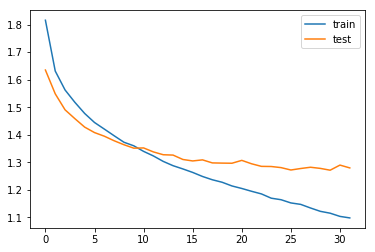

In [8]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

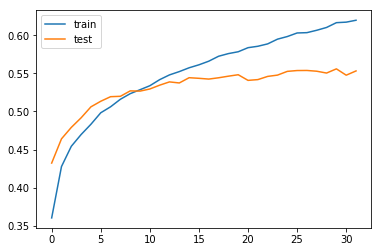

In [9]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()